# CAB420, Practical 4, Question 3 Solution
## Exploring Other Layers

There are many changes or extensions that you could make to the above networks to further explore deep convolutional neural networks. In your own time, try the following:
* Add dropout to one (or both) networks in a few locations. Use ``SpatialDropout2D`` layers after convolution layers, and ``Dropout`` layers after dense layers. With dropout layers in the network, consider:
  * How is the number of iterations required to train the network to convergence impacted by the addition of dropout?
  * Are any differences with respect to overfitting observed?
  * What happens as the dropout probability is increased?
* Add Batch Normalisation to the network in a few locations. With batch normalisation in the network, consider:
  * How is the number of iterations required to train the network to convergence impacted by the addition of batch normalisation?
  * Are any differences with respect to overfitting observed?
* Change the ``padding`` type used by the convolutional layers. Observe what happens to the representation size when you change this.
* Change the activation used. Consider using an activation such as Swish, or an ELU, rather than the standard relu (though leave the final activation as a softmax). Train the network with the alternate activation and note any changes.

### Relevant Examples

The DCNN examples from this week, in particular ``CAB420_DCNNs_Example_1_Classification_with_Deep_Learning.ipynb`` is a good starting point and has examples of how to build and train a neural network.

The additional example, ``CAB420_DCNNs_Additional_Example_4_Layer_Order_and_Overfitting.ipynb`` is also worth a look as it shows how to use layers like dropout and batchnorm.

Finally, this question should build directly of your answers to Q1 and Q2 as well.

### Suggested Packages

TensorFlow and Keras are your friends here. Matplotlib and maybe seaborn will be good for plotting, and sklearn also provides some useful functionality for confusion matricies and accuracy metrics.

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import numpy

## Loading the Data

CIFAR-10 is built into keras, so we can load that directly. Note that we will:
* Convert the y-data to categoricals
* Plot some example images as a sanity check

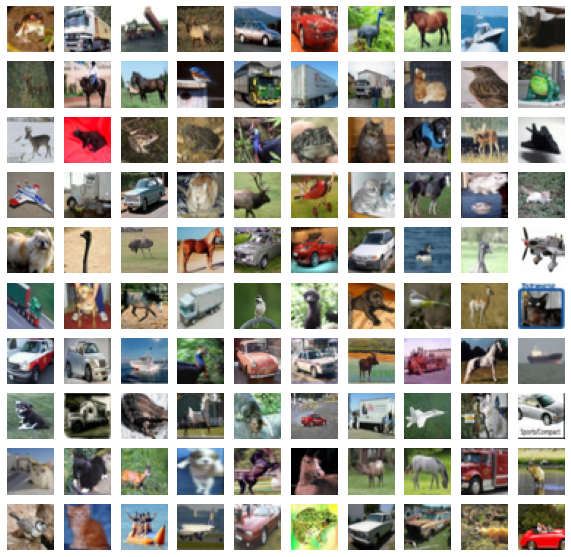

In [2]:
(train, train_y), (test, test_y) = keras.datasets.cifar10.load_data()

train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,:])
    ax.axis('off')

## A Baseline

We'll start with a baseline network to compare to. I'm going to use my network from the solution to Q2, and add/change this network.

In [3]:
# network input, images are 32 pixels square, and colour; so our size is 32 x 32 x 3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')

# 3x3 conv block, we have two conv layers, and a max-pooling. The conv layers have identical parameters
# and are simply separated by an activation, in our case, relu
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(inputs)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, increase filters, same structure as above, but now with 16 filters
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, further increase filters to 32, again the structure is the same
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# flatten layer
x = layers.Flatten()(x)

# dense layer, 512 neurons
x = layers.Dense(512, activation='relu')(x)

# the output, 10 neurons for 10 classes, and a softmax activation
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print a summary
model_vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg_for_cifar10')
model_vgg.summary()

Model: "vgg_for_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 activation (Activation)     (None, 32, 32, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                   

For simplicity I'll create a single function to wrap up all model training and evaluation. As each model will be trained and evaluated in the same way, this can be done to keep things nice and compact.

Note that while we saw some overfitting with 12 epochs, we'll leave all networks to train for this duration for fair comparison.

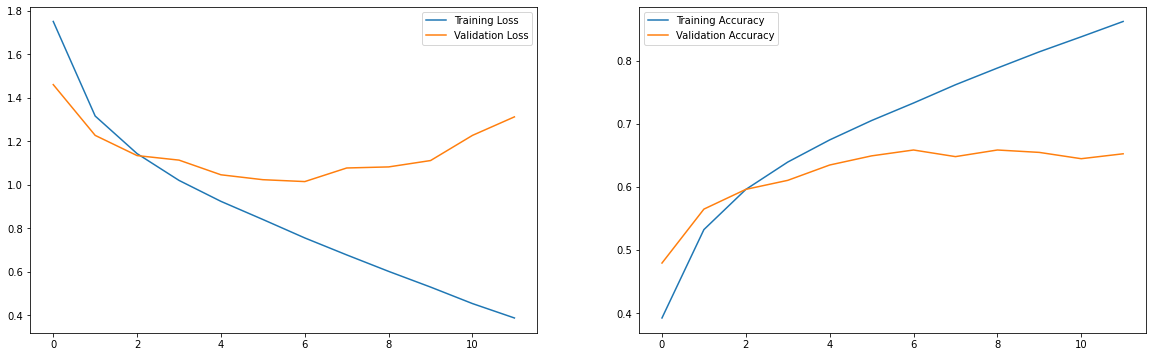

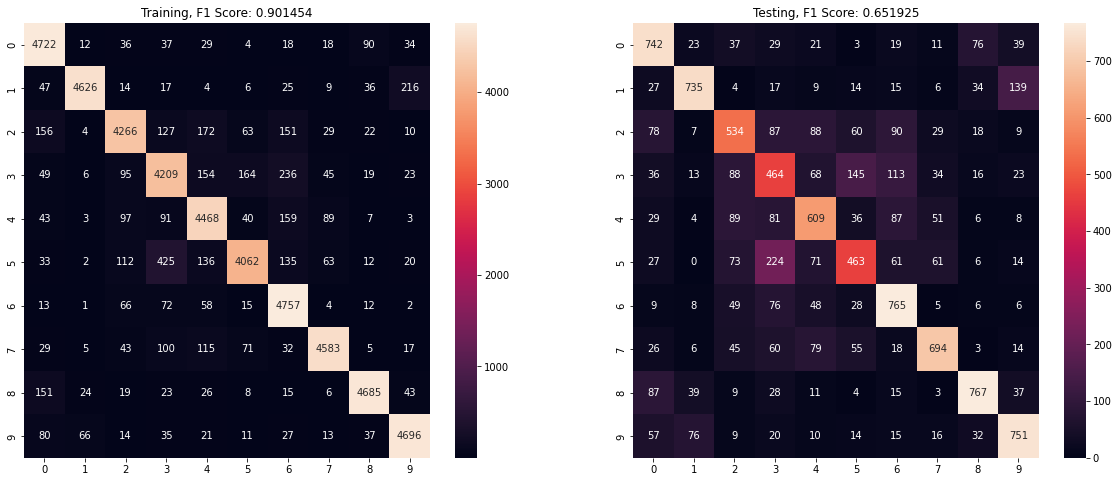

In [4]:
def train_and_eval(model, train, train_y, test, test_y):

    # compile the network
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    # fit the model
    history = model.fit(train, train_y,
                        batch_size=128,
                        epochs=12,
                        validation_data=(test, test_y), verbose=False)

    # plot training and validation loss and accuracy
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend()

    # plot confusion matrices and F1 scores
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    pred = model.predict(train, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    ax = fig.add_subplot(1, 2, 2)    
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))
    
train_and_eval(model_vgg, train, train_y, test, test_y)    

The baseline performs very similar to what we saw in Q2. There are some small differences due to the variation that we see across different training runs.

### Adding Dropout

I'll add dropout at the end of each conv block, and before the final dense layer.

In [5]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')

# 3x3 conv block
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(inputs)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
# spatial dropout, this will, for any batch, randomly drop 10% of the filters
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, increase filters
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
# spatial dropout, this will, for any batch, randomly drop 10% of the filters
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, further increase filters
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
# spatial dropout, this will, for any batch, randomly drop 10% of the filters
x = layers.SpatialDropout2D(0.1)(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# flatten layer
x = layers.Flatten()(x)

# dense layer, 256 neurons
x = layers.Dense(512, activation='relu')(x)
# regular dropout, this will, for any batch, randomly drop 25% of the neurons. Generally we can
# use high levels of dropout with dense layers than with convolutional layers
x = layers.Dropout(0.25)(x)

# the output, one neuron for the cost, relu activation becuase the cost must be positive
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print a summary
model_vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg_for_cifar10')
model_vgg.summary()

Model: "vgg_for_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 8)         584       
                                                                 
 activation_7 (Activation)   (None, 32, 32, 8)         0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 32, 32, 8)        0         
 ropout2D)                                                       
                                                   

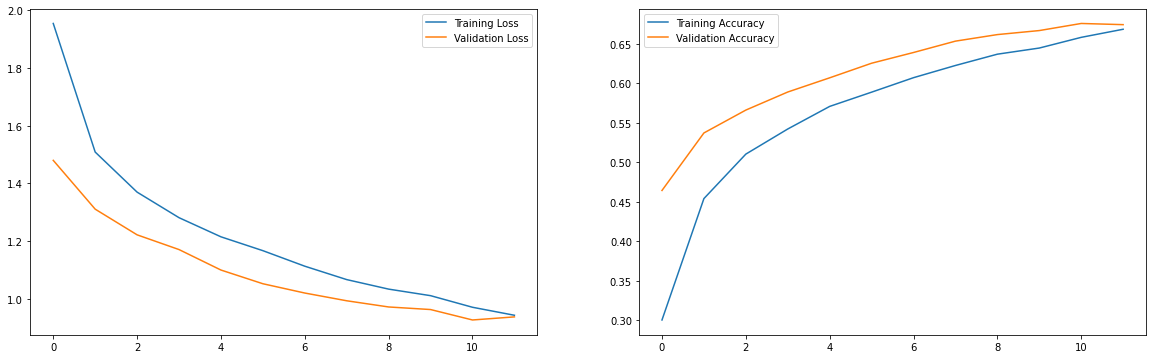

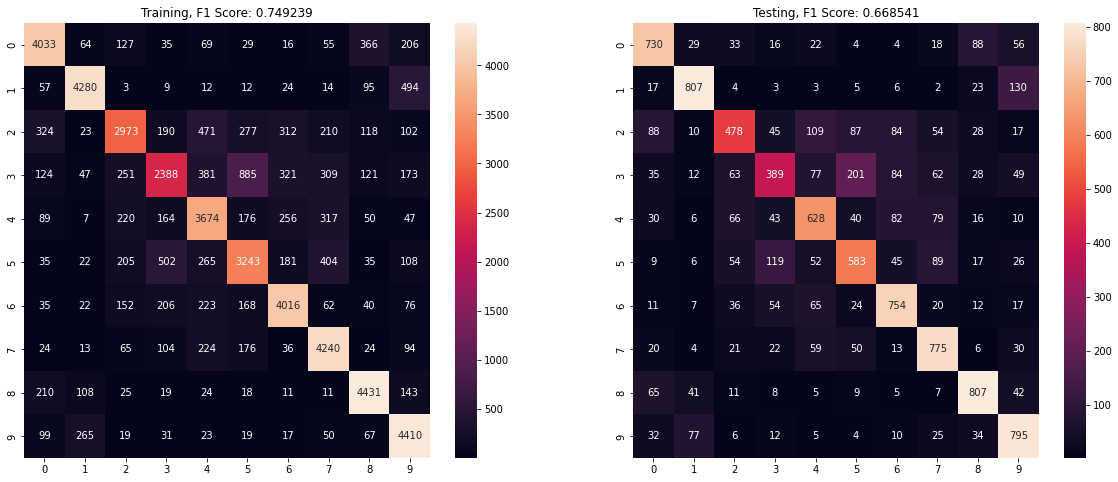

In [6]:
train_and_eval(model_vgg, train, train_y, test, test_y)    

The end results show similar accuracy on the test set, though from the training plots we see convergence is much more gradual, and we haven't yet begun to overfit. We could afford to train for a few more epochs here.

### Batch Normalisation

I'll add batch normalisation now. Essentially, I'll make the same changes I made with dropout, but where I had a dropout layer I'll place a batch normalisation layer.

In [7]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')

# 3x3 conv block
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(inputs)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(x)
# adding batch norm
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, increase filters
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
# adding batch norm
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, further increase filters
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
# adding batch norm
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# flatten layer
x = layers.Flatten()(x)

# dense layer, 256 neurons
x = layers.Dense(512, activation=None)(x)
# adding batch norm, note that I've changed the activation above to None to place batch norm
# before the activation function
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# the output, one neuron for the cost, relu activation becuase the cost must be positive
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print a summary
model_vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg_for_cifar10')
model_vgg.summary()

Model: "vgg_for_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 activation_12 (Activation)  (None, 32, 32, 8)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 8)         584       
                                                                 
 activation_13 (Activation)  (None, 32, 32, 8)         0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 8)        32        
 ormalization)                                                   
                                                   

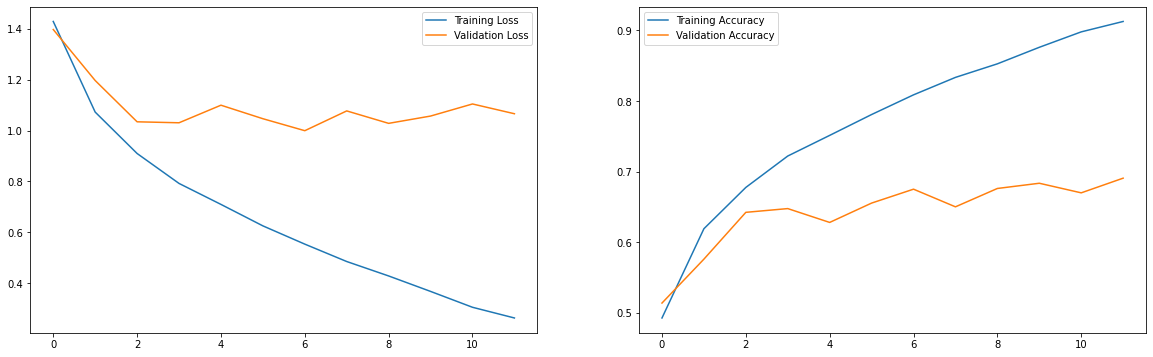

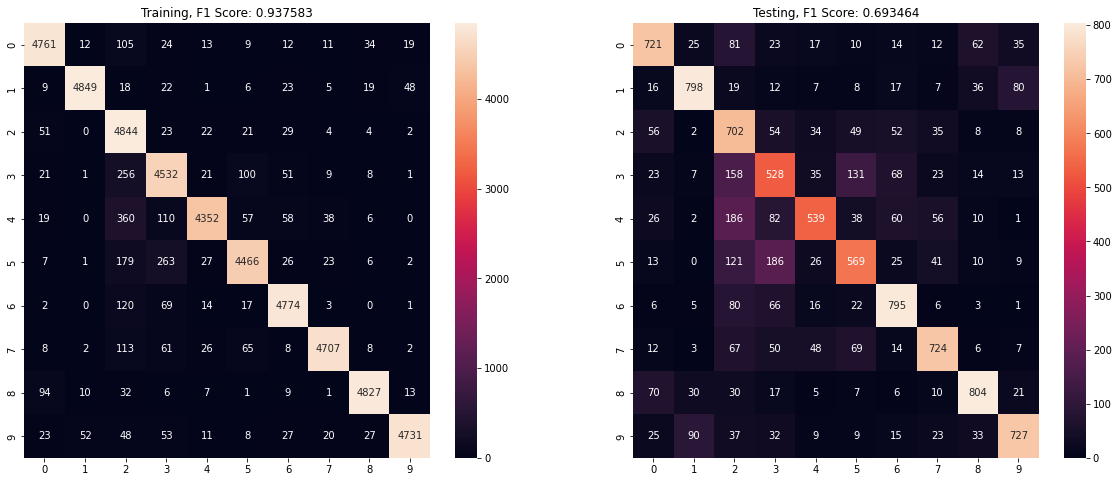

In [8]:
train_and_eval(model_vgg, train, train_y, test, test_y)    

Results wise, I see that:
* Overfitting is back, and in fact happened quicker. Batch norm has sped up training
* I've got a few percent better performance on the test set

### Changing Padding Type

I'll change it to ``valid``, which effectivley means no padding.

Note that to get this to run, I've got to remove the last max pooling layer.

In [9]:
# network input, images are 32 pixels square, and colour; so our size is 32 x 32 x 3
inputs = keras.Input(shape=(32, 32, 3, ), name='img')

# 3x3 conv block, note that padding is now 'valid'
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='valid', activation=None)(inputs)
x = layers.Activation('relu')(x)
# padding = 'valid'
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='valid', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, padding = 'valid'
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='valid', activation=None)(x)
x = layers.Activation('relu')(x)
# padding = 'valid'
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='valid', activation=None)(x)
x = layers.Activation('relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, padding = 'valid'
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation=None)(x)
x = layers.Activation('relu')(x)
# padding = 'valid'
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation=None)(x)
x = layers.Activation('relu')(x)
# removing max pooling
#x = layers.MaxPool2D(pool_size=(2, 2))(x)

# flatten layer
x = layers.Flatten()(x)

# dense layer, 512 neurons
x = layers.Dense(512, activation='relu')(x)

# the output, 10 neurons for 10 classes, and a softmax activation
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print a summary
model_vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg_for_cifar10')
model_vgg.summary()

Model: "vgg_for_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 30, 8)         224       
                                                                 
 activation_19 (Activation)  (None, 30, 30, 8)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 8)         584       
                                                                 
 activation_20 (Activation)  (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                   

From the above, we can see a very different sized representation at the end of our convolution stack than what we had. Previously, this has been (4, 4, 32) (with 3 max-poolings), where here we have (1, 1, 32) with only 2 max-poolings. The lack of padding means that each of our conv2D operations reduces the representation size slightly. With `padding='same'`, for a convolution layer with an input size of (28, 28), the output is also (28, 28). With `padding='valid'`, we go from (28, 28) to (26, 26), and we the same reduction elsewhere. Across a number of convolution operations, this gradually shrinks our representation, until we get to the (1, 1, 32) that we have here.  

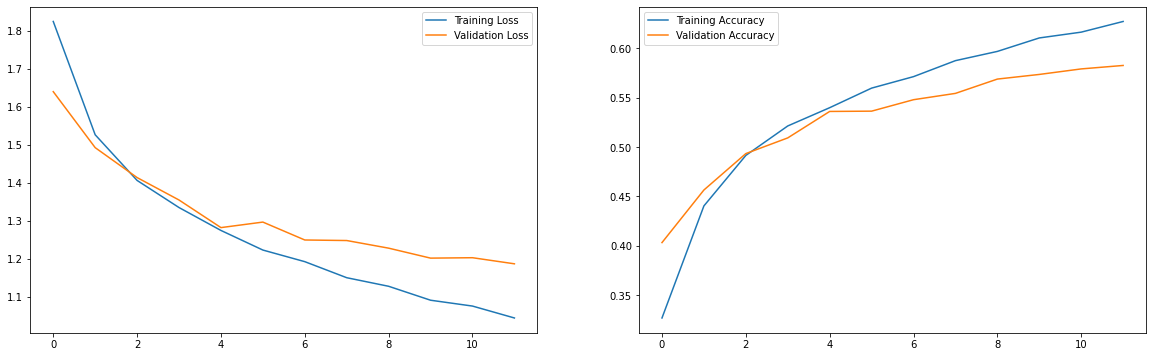

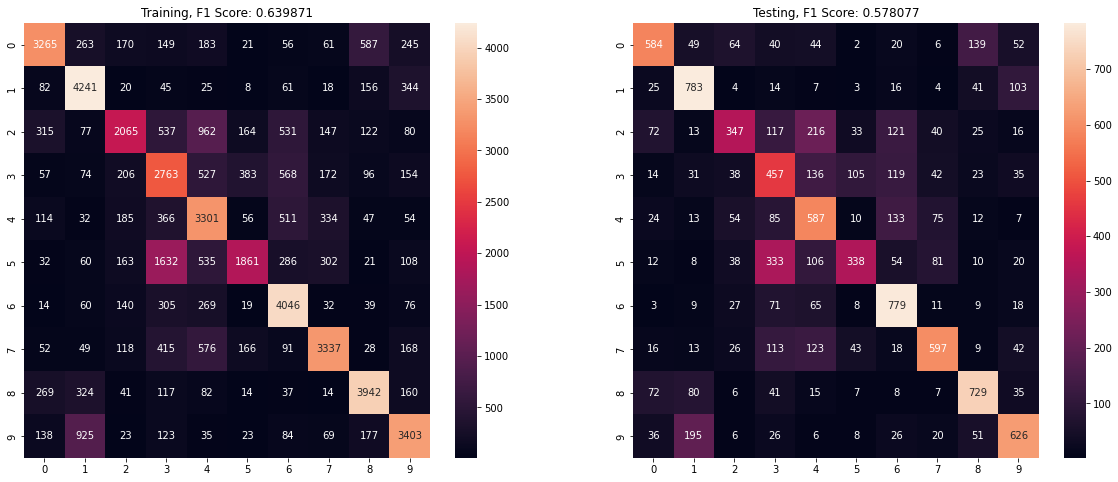

In [10]:
train_and_eval(model_vgg, train, train_y, test, test_y)    

Results wise, the performance is a bit interesting. We see a performance drop, but we also see training slow and overfitting become less of an issue. The impact of this change is that our network actually becomes a bit harder to learn. Note this is not necessarily a case of the change in padding type making learning slower, but rather having our network get down to such a small representation makes out network harder to train.

### Activation Function

Finally, we'll change the activation. I'm going to put a [swish](https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820) function everywhere, except for the softmax that will stay as is.

In [11]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')

# 3x3 conv block
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(inputs)
x = layers.Activation('swish')(x)
x = layers.Conv2D(filters=8, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('swish')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, increase filters
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('swish')(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('swish')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# 3x3 conv block, further increase filters
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('swish')(x)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=None)(x)
x = layers.Activation('swish')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)

# flatten layer
x = layers.Flatten()(x)

# dense layer, 256 neurons
x = layers.Dense(512, activation='swish')(x)

# the output, one neuron for the cost, relu activation becuase the cost must be positive
outputs = layers.Dense(10, activation='softmax')(x)

# build the model, and print a summary
model_vgg = keras.Model(inputs=inputs, outputs=outputs, name='vgg_for_cifar10')
model_vgg.summary()

Model: "vgg_for_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
 activation_25 (Activation)  (None, 32, 32, 8)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 8)         584       
                                                                 
 activation_26 (Activation)  (None, 32, 32, 8)         0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                   

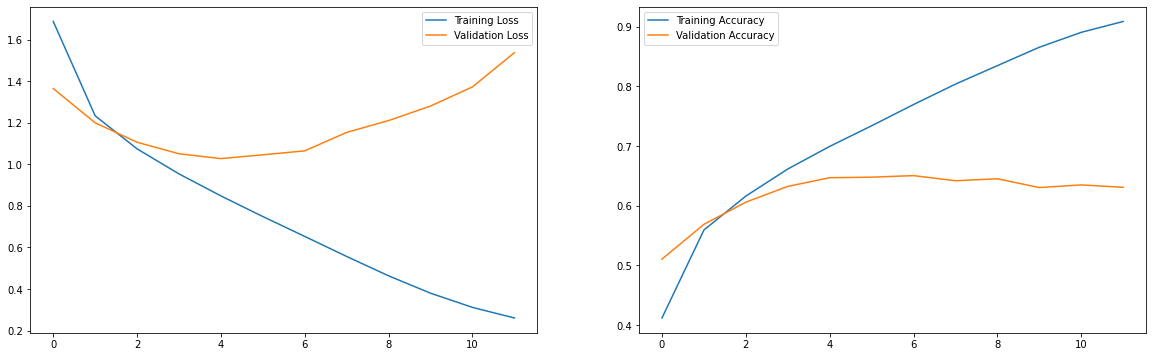

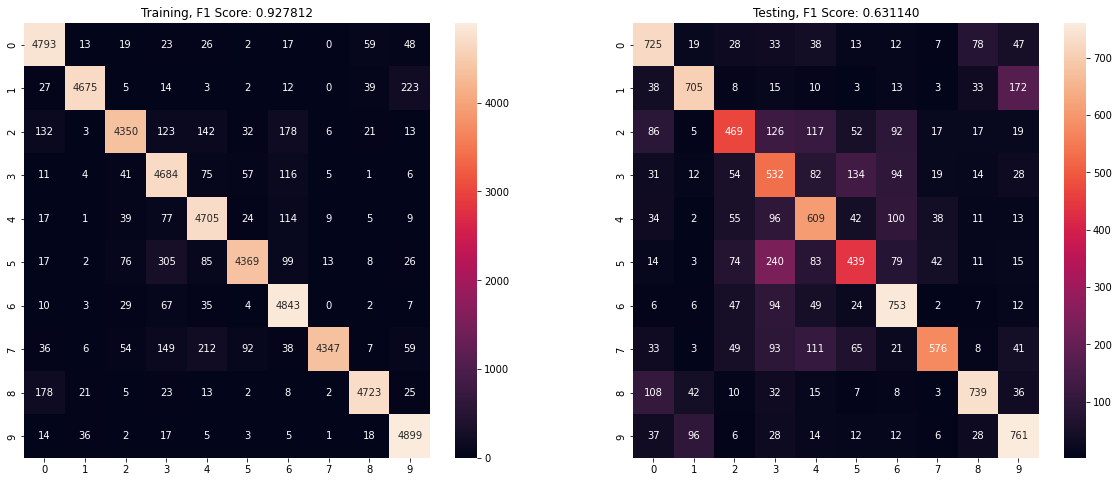

In [12]:
train_and_eval(model_vgg, train, train_y, test, test_y)    

With swish, things don't change much - if anything learning is slightly faster. In general, changing activations won't make a huge difference, but some activations such as swish do have some nice properties around having nice smooth gradients that can make learning easier. This is why we see the (perhaps) slightly faster training here, but not much else.